In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import tensorflow as tf

In [2]:
import pickle
with open('cache_dict_float32','rb') as f:
    cache_dict_float32 = pickle.load(f)
    
stage_list = cache_dict_float32['stage_list_float32']
time_length_list = cache_dict_float32['time_length_list']
latent_scen_4_meansd = cache_dict_float32['latent_scen_4_meansd']

stage_list[0].dtype

dtype('float32')

In [3]:
stage = stage_list[0] 
stage.shape # stage 1 obs


(202, 4, 193)

In [4]:
meansd = np.array(latent_scen_4_meansd[0],dtype='float32') # stage 1 
time_length = np.array(time_length_list[0],dtype='float32') # stage 1

meansd.shape,time_length.shape

((5, 5, 2), (4, 2))

In [5]:
period_num = meansd.shape[0] # in stage 1 -> 5
var_num = meansd.shape[1] # always 5
durations_num = time_length.shape[0] # in stage 1 -> 4
assert time_length.shape[0] == period_num - 1
replay_num = stage.shape[0] # obs

period_num,var_num,durations_num,replay_num

(5, 5, 4, 202)

In [6]:
emu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
esd = np.array([stage[:,0,:80].std(),stage[:,0,80:131].std(),stage[:,0,131:].std()],dtype='float32')

emu

array([ 21.84028435,  40.84634018,   5.01133823], dtype=float32)

In [7]:
%%time
import edward as ed
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

Wall time: 14 s


In [8]:
# priori model test

sess = ed.get_session()
tf.global_variables_initializer().run()

In [9]:
stage_length = stage.shape[2]
time_axis = np.arange(stage_length, dtype='float32')
_time_axis = np.tile(time_axis,(202, 2, 1)) # add batch...
_time_axis.shape

(202, 2, 193)

In [10]:
# MODEL

# 

durations = ed.models.Normal(loc = [80.0,51.0], scale=[3.0,10.0], sample_shape=replay_num) # 202 * 2 matrix
breaks = tf.cumsum(durations, axis=1) # 202 * 2 matrix
_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,2)),(1,2,0))  
_mask = tf.where(_time_axis > _breaks, tf.ones((replay_num,2,stage_length),dtype=tf.int32), tf.zeros((replay_num,2,stage_length),dtype=tf.int32))
index = tf.reduce_sum(_mask, axis=1)

# 几个参数就不一样了

_shift_mu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
_ctrl_mu  = np.array([stage[:,1,:80].mean(),stage[:,1,80:131].mean(),stage[:,1,131:].mean()],dtype='float32')
_x_mu     = np.array([stage[:,2,:80].mean(),stage[:,2,80:131].mean(),stage[:,2,131:].mean()],dtype='float32')
_move_mu  = np.array([stage[:,3,:80].mean(),stage[:,3,80:131].mean(),stage[:,3,131:].mean()],dtype='float32')
_move_sd  = np.array([stage[:,3,:80].std(), stage[:,3,80:131].std(), stage[:,3,131:].std() ],dtype='float32')

shift_mu = ed.models.Exponential(rate = 1/_shift_mu)
ctrl_mu = ed.models.Exponential(rate = 1/_ctrl_mu)
x_mu = ed.models.Exponential(rate = 1/_x_mu)
move_mu = ed.models.Exponential(rate = 1/_move_mu) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。
move_sd = ed.models.Exponential(rate = 1/_move_sd) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。

def share_params_into_period(var, index):
    var_list = []
    for i in range(replay_num):
        var_list.append(tf.gather(var,index[i]))
    var_along_replay = tf.stack(var_list)
    return var_along_replay

shift_mu_time = share_params_into_period(shift_mu, index)
ctrl_mu_time = share_params_into_period(ctrl_mu, index)
x_mu_time = share_params_into_period(x_mu, index)
move_mu_time = share_params_into_period(move_mu, index)
move_sd_time = share_params_into_period(move_sd, index)

pressing_shift = ed.models.Poisson(rate = shift_mu_time)
pressing_ctrl = ed.models.Poisson(rate = ctrl_mu_time)
pressing_x = ed.models.Poisson(rate = x_mu_time)
move = ed.models.Normal(loc = shift_mu_time, scale = move_sd_time)

move

<ed.RandomVariable 'Normal_5/' shape=(202, 193) dtype=float32>

In [11]:
# 虽然这个代码块运行的时候里面还有些变量没定义。。
# 用了这个和新实现的轮换MH算法才发现那些泊松分布的变量很难优化，而duration和move的参数则无压力。可以把那些泊松分布的proposal分布标准差再
# 改小点
def diagnose(channel = None, focus = 0):
    channel = focus if channel == None else channel
    plt.plot(qshift_mu.params.eval()[:,channel])
    plt.title('qshift_mu 0')
    plt.show()
    plt.plot(qctrl_mu.params.eval()[:,channel])
    plt.title('qctrl_mu 0')
    plt.show()
    plt.plot(qx_mu.params.eval()[:,channel])
    plt.title('qx_mu 0')
    plt.show()
    plt.plot(qmove_mu.params.eval()[:,channel])
    plt.title('qmove_mu 0')
    plt.show()
    plt.plot(qmove_sd.params.eval()[:,channel])
    plt.title('qmove_sd 0')
    plt.show()
    plt.plot(qdurations.params[:,0,:].eval())
    plt.show('gdurations replay 0')
    plt.show()


In [12]:

# Inference
T = 30000

idurations = np.ones([T,replay_num,2],dtype='float32')
idurations[0,:,:] = np.array([80.0,51.0],dtype='float32')
qdurations = ed.models.Empirical(tf.Variable(idurations))

# 神他妈一堆样板代码，不过没精力想怎么重构了
ishift_mu = np.ones([T,3],dtype='float32')
ishift_mu[0,:] = _shift_mu
qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))

ictrl_mu = np.ones([T,3],dtype='float32')
ictrl_mu[0,:] = _ctrl_mu
qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))

ix_mu = np.ones([T,3],dtype='float32')
ix_mu[0,:] = _x_mu
qx_mu = ed.models.Empirical(tf.Variable(ix_mu))

imove_mu = np.ones([T,3],dtype='float32')
imove_mu[0,:] = _move_mu
qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))

imove_sd = np.ones([T,3],dtype='float32')
imove_sd[0,:] = _move_sd
qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))


# proposal variable

gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1,0.1],[replay_num,1]).astype('float32'))

poi_scale = 0.000025 # 经实验发现那些泊松的参数接受率太低，故降低游走标准差
sd_scale = 0.1 # 经实验发现scale有趋势，且在30000次以内不能终结，于是加大其标准差增快搜索

gshift_mu = ed.models.Normal(loc = shift_mu, scale = [poi_scale, poi_scale, poi_scale])
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [poi_scale, poi_scale, poi_scale])
gx_mu = ed.models.Normal(loc = x_mu, scale = [poi_scale, poi_scale, poi_scale])
gmove_mu = ed.models.Normal(loc = move_mu, scale = [0.01,0.01,0.01])
gmove_sd = ed.models.Normal(loc = move_sd, scale = [sd_scale, sd_scale, sd_scale])


In [12]:
inference = ed.MetropolisHastings({durations: qdurations, 
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      proposal_vars = {durations: gdurations, 
                                       shift_mu: gshift_mu, ctrl_mu: gctrl_mu, x_mu: gx_mu,move_mu: gmove_mu,move_sd: gmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [13]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 436s | Acceptance Rate: 0.003


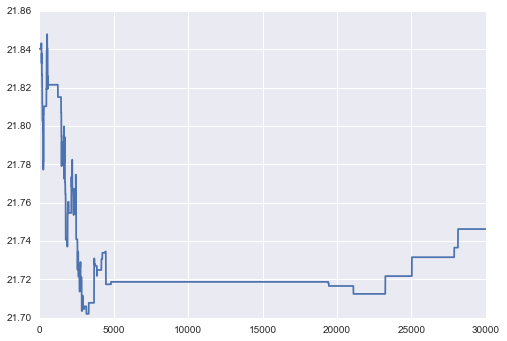

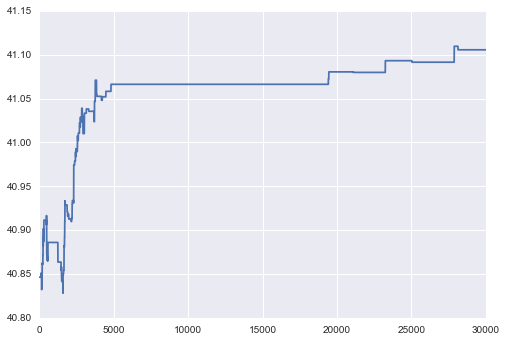

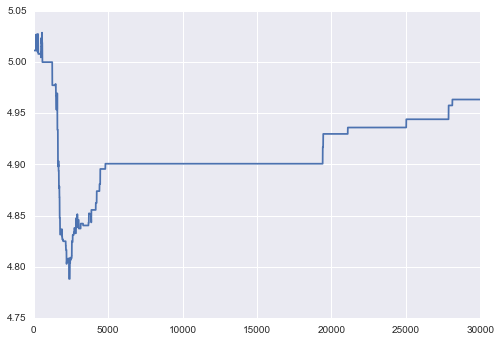

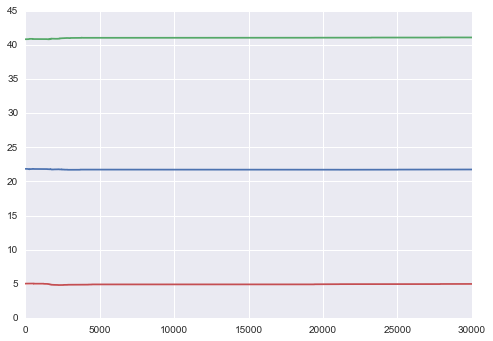

In [14]:
trace = qshift_mu.params.eval()
plt.plot(trace[:,0])
plt.show()
plt.plot(trace[:,1])
plt.show()
plt.plot(trace[:,2])
plt.show()
plt.plot(trace)
plt.show()

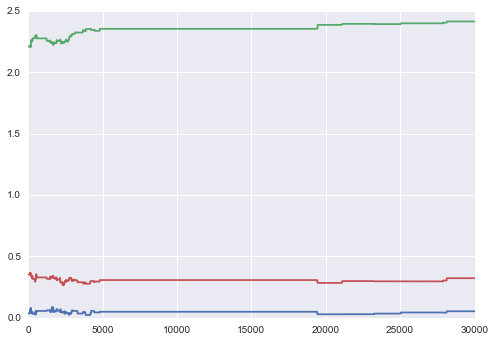

In [16]:
plt.plot(qctrl_mu.params.eval())

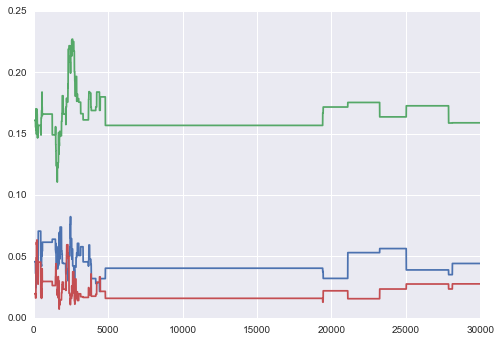

In [15]:
plt.plot(qx_mu.params.eval())

In [17]:
# Inference
T = 10000

idurations = np.ones([T,replay_num,2],dtype='float32')
idurations[0,:,:] = np.array([80.0,51.0],dtype='float32')
qdurations = ed.models.Empirical(tf.Variable(idurations))

# 神他妈一堆样板代码，不过没精力想怎么重构了
ishift_mu = np.ones([T,3],dtype='float32')
ishift_mu[0,:] = _shift_mu
qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))

ictrl_mu = np.ones([T,3],dtype='float32')
ictrl_mu[0,:] = _ctrl_mu
qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))

ix_mu = np.ones([T,3],dtype='float32')
ix_mu[0,:] = _x_mu
qx_mu = ed.models.Empirical(tf.Variable(ix_mu))

imove_mu = np.ones([T,3],dtype='float32')
imove_mu[0,:] = _move_mu
qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))

imove_sd = np.ones([T,3],dtype='float32')
imove_sd[0,:] = _move_sd
qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))


In [18]:
inference = ed.SGHMC({durations: qdurations, 
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [19]:
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 156s | Acceptance Rate: 1.000


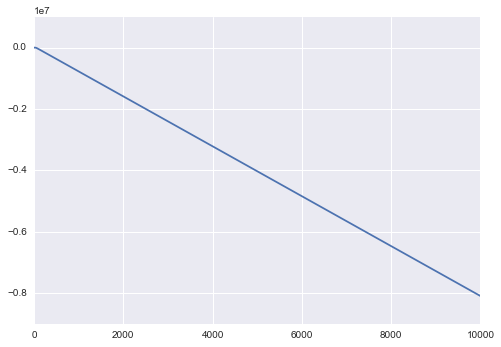

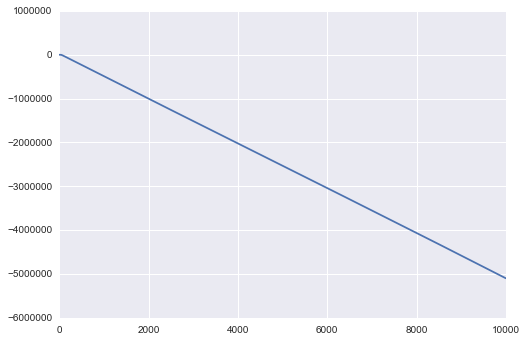

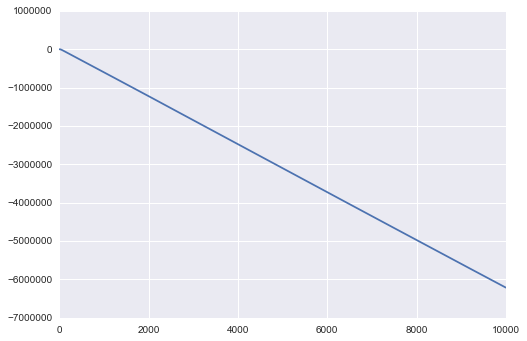

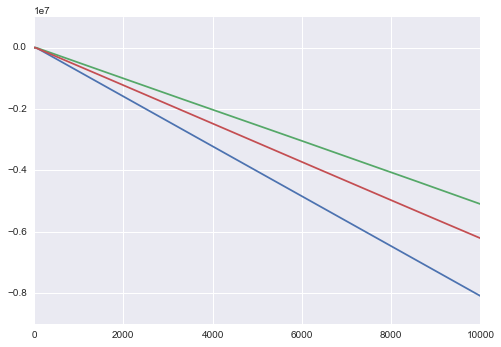

In [20]:
trace = qshift_mu.params.eval()
plt.plot(trace[:,0])
plt.show()
plt.plot(trace[:,1])
plt.show()
plt.plot(trace[:,2])
plt.show()
plt.plot(trace)
plt.show()

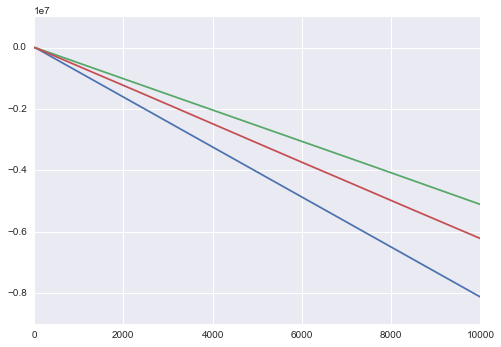

In [21]:
plt.plot(qctrl_mu.params.eval())

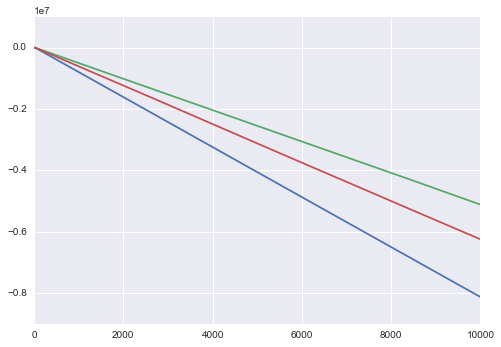

In [22]:
plt.plot(qx_mu.params.eval())

In [23]:
inference = ed.HMC({durations: qdurations, 
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [24]:
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 508s | Acceptance Rate: 0.000


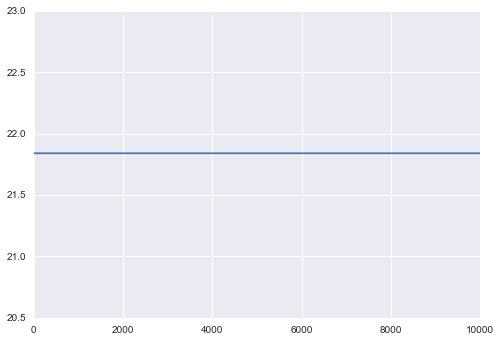

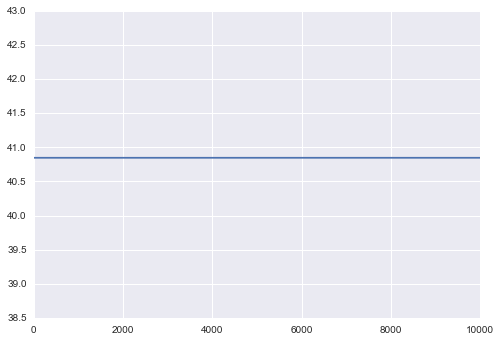

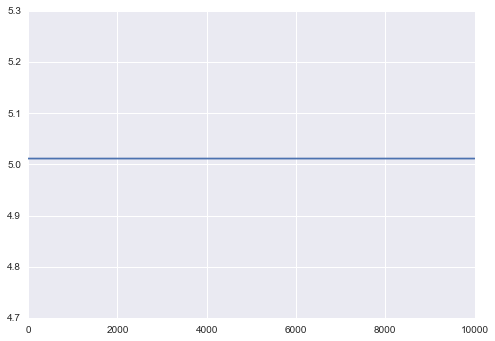

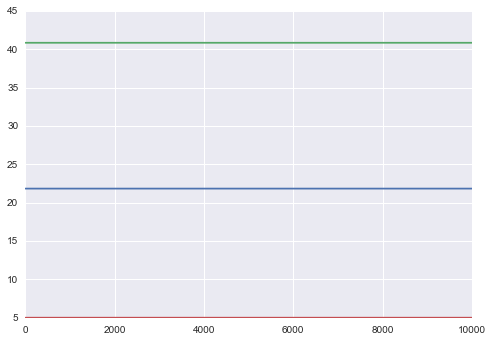

In [25]:
trace = qshift_mu.params.eval()
plt.plot(trace[:,0])
plt.show()
plt.plot(trace[:,1])
plt.show()
plt.plot(trace[:,2])
plt.show()
plt.plot(trace)
plt.show()

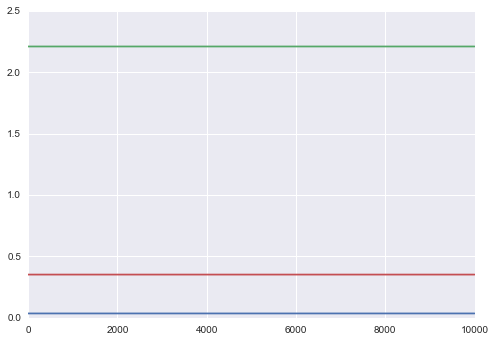

In [26]:
plt.plot(qctrl_mu.params.eval())

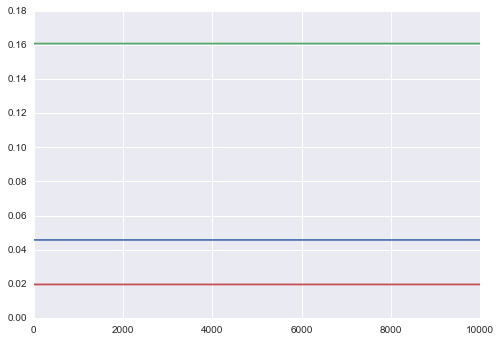

In [27]:
plt.plot(qx_mu.params.eval())

试试我新实现的轮换MH算法，如果效果还不佳再封装一层自动把所有变量分开来的。

In [13]:
from metropolis_hastings_y import MetropolisHastingsY

In [14]:
inference = MetropolisHastingsY({durations: qdurations, 
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      proposal_vars = {durations: gdurations, 
                                       shift_mu: gshift_mu, ctrl_mu: gctrl_mu, x_mu: gx_mu,move_mu: gmove_mu,move_sd: gmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [15]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 602s | Acceptance Rate: 3.100


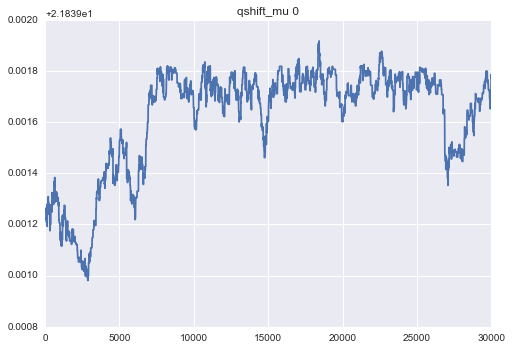

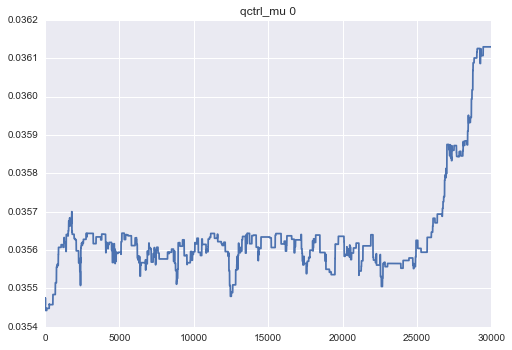

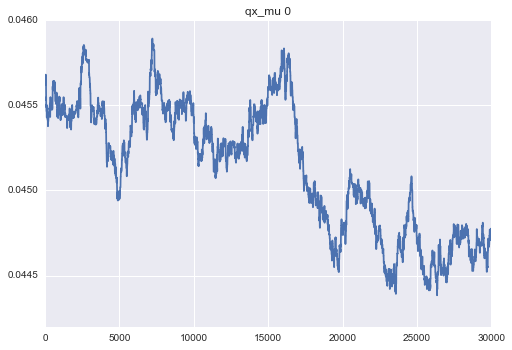

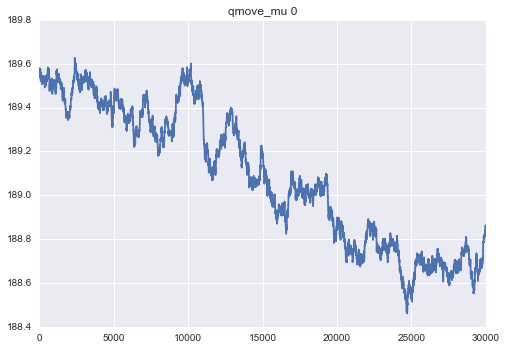

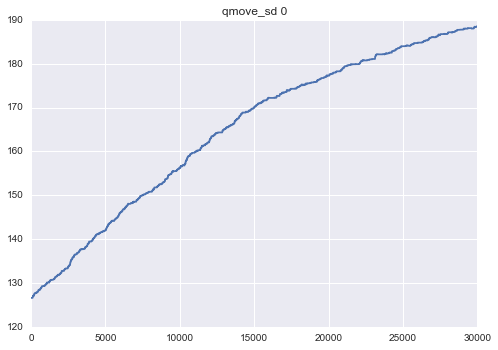

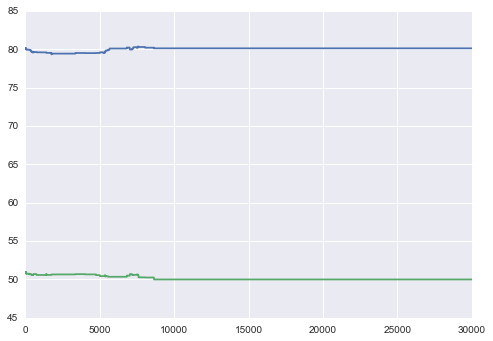

In [16]:
diagnose()

In [17]:
qshift_mu.params.eval().shape

(30000, 3)

(array([   54.,   418.,   994.,   498.,   952.,  2321.,  6545.,  6174.,
         1919.,   125.]),
 array([ 21.84035301,  21.84040947,  21.84046593,  21.84052238,
         21.84057884,  21.8406353 ,  21.84069176,  21.84074821,
         21.84080467,  21.84086113,  21.84091759]),
 <a list of 10 Patch objects>)

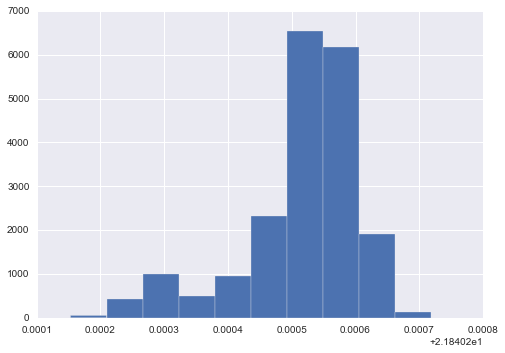

In [18]:
plt.hist(qshift_mu.params.eval()[10000:,0])

(array([ 1038.,  1850.,  1627.,  2493.,  4132.,  2332.,  2258.,  1321.,
         2045.,   904.]),
 array([ 40.84611893,  40.84622154,  40.84632416,  40.84642677,
         40.84652939,  40.846632  ,  40.84673462,  40.84683723,
         40.84693985,  40.84704247,  40.84714508]),
 <a list of 10 Patch objects>)

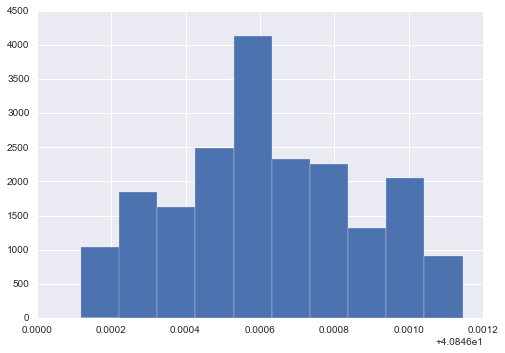

In [19]:
plt.hist(qshift_mu.params.eval()[10000:,1])

(array([    24.,    153.,     82.,    116.,    273.,    293.,    220.,
          1510.,   6889.,  10440.]),
 array([ 5.0115304 ,  5.01154919,  5.01156797,  5.01158676,  5.01160555,
         5.01162434,  5.01164312,  5.01166191,  5.0116807 ,  5.01169949,
         5.01171827]),
 <a list of 10 Patch objects>)

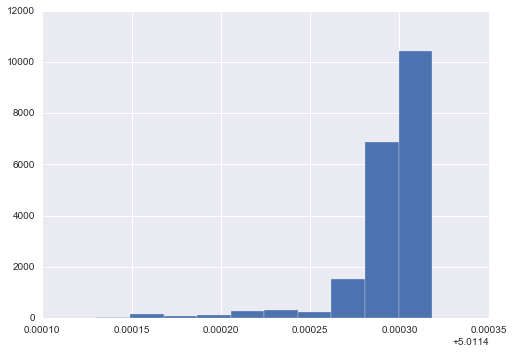

In [20]:
plt.hist(qshift_mu.params.eval()[10000:,2])

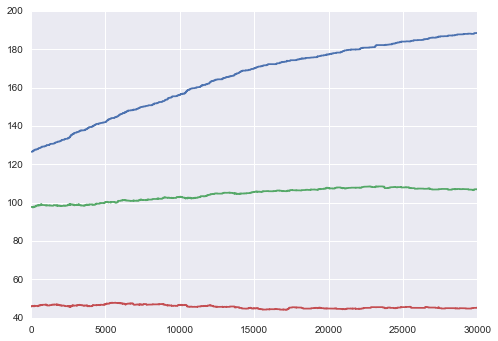

In [22]:
plt.plot(qmove_sd.params.eval())

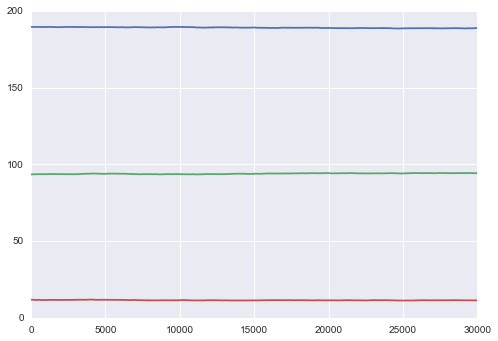

In [23]:
plt.plot(qmove_mu.params.eval())

OK..让我们回到初值乱设的时光看看HMZ采样的效果

In [20]:
# Inference
T = 30000

#idurations = np.ones([T,replay_num,2],dtype='float32')
#idurations[0,:,:] = np.array([80.0,51.0],dtype='float32')
#qdurations = ed.models.Empirical(tf.Variable(idurations))
#qdurations = ed.models.Empirical(tf.Variable(tf.ones((T,replay_num,2))))
# 这里还从1开始实在不能收敛，试试从等分点开始如何
idurations = np.ones([T,replay_num,2],dtype='float32')
idurations[0,:,:] = np.array([replay_num/3,replay_num/3],dtype='float32')
qdurations = ed.models.Empirical(tf.Variable(idurations))

# 神他妈一堆样板代码，不过没精力想怎么重构了
#ishift_mu = np.ones([T,3],dtype='float32')
#ishift_mu[0,:] = _shift_mu
#qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))
qshift_mu = ed.models.Empirical(tf.Variable(tf.ones((T,3))))

#ictrl_mu = np.ones([T,3],dtype='float32')
#ictrl_mu[0,:] = _ctrl_mu
#qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))
qctrl_mu = ed.models.Empirical(tf.Variable(tf.ones((T,3))))

#ix_mu = np.ones([T,3],dtype='float32')
#ix_mu[0,:] = _x_mu
#qx_mu = ed.models.Empirical(tf.Variable(ix_mu))
qx_mu = ed.models.Empirical(tf.Variable(tf.ones((T,3))))

#imove_mu = np.ones([T,3],dtype='float32')
#imove_mu[0,:] = _move_mu
#qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))
qmove_mu = ed.models.Empirical(tf.Variable(tf.ones((T,3))))

#imove_sd = np.ones([T,3],dtype='float32')
#imove_sd[0,:] = _move_sd
#qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))
qmove_sd = ed.models.Empirical(tf.Variable(tf.ones((T,3))))


# proposal variable

gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1,0.1],[replay_num,1]).astype('float32'))

#poi_scale = 0.000025 # 经实验发现那些泊松的参数接受率太低，故降低游走标准差
poi_scale = 0.01
sd_scale = 0.1 # 经实验发现scale有趋势，且在30000次以内不能终结，于是加大其标准差增快搜索

gshift_mu = ed.models.Normal(loc = shift_mu, scale = [poi_scale, poi_scale, poi_scale])
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [poi_scale, poi_scale, poi_scale])
gx_mu = ed.models.Normal(loc = x_mu, scale = [poi_scale, poi_scale, poi_scale])
gmove_mu = ed.models.Normal(loc = move_mu, scale = [0.01,0.01,0.01])
gmove_sd = ed.models.Normal(loc = move_sd, scale = [sd_scale, sd_scale, sd_scale])


In [21]:
from metropolis_hastings_y import MetropolisHastingsY

inference = MetropolisHastingsY({durations: qdurations, 
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      proposal_vars = {durations: gdurations, 
                                       shift_mu: gshift_mu, ctrl_mu: gctrl_mu, x_mu: gx_mu,move_mu: gmove_mu,move_sd: gmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [22]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 606s | Acceptance Rate: 1.925


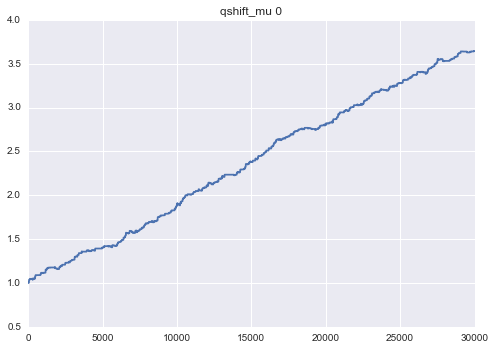

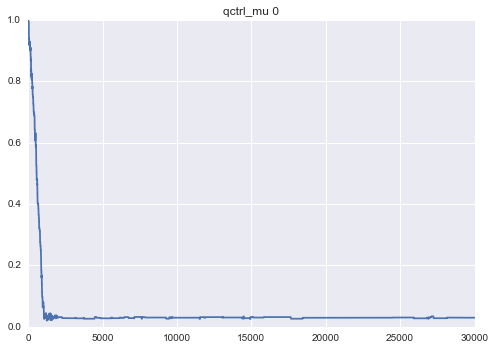

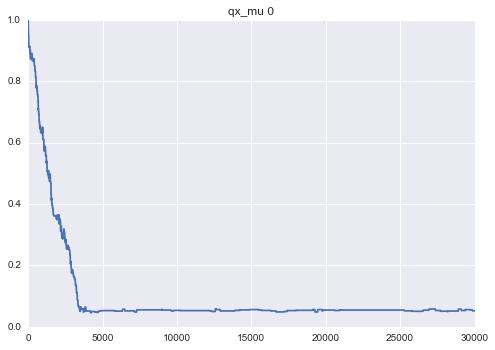

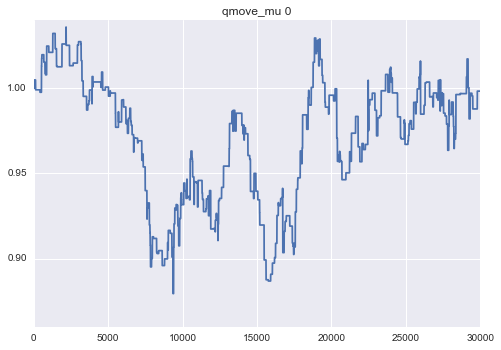

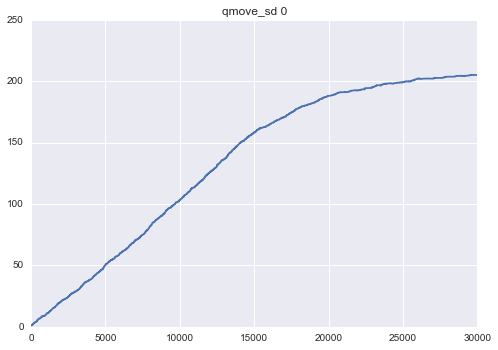

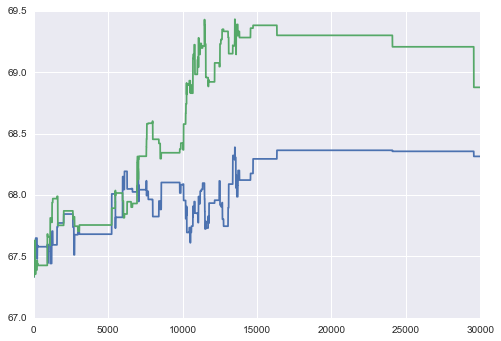

In [23]:
diagnose()

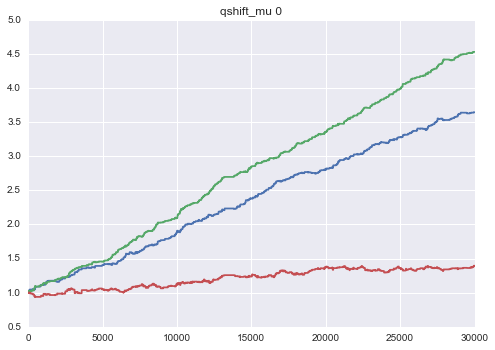

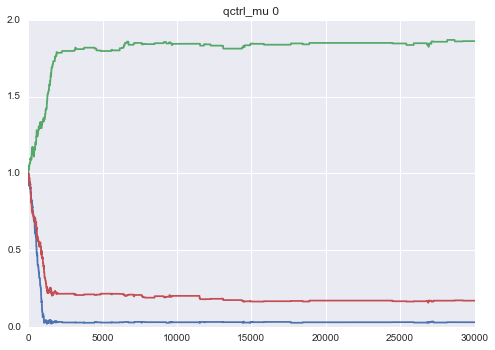

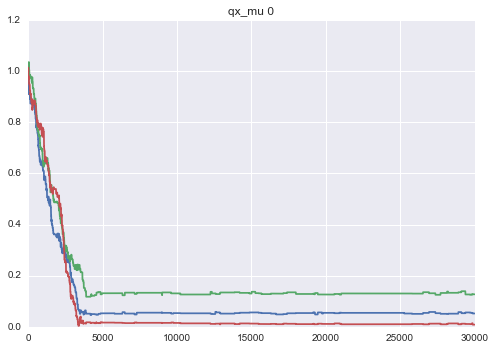

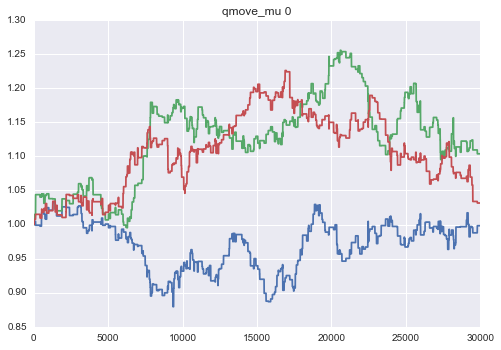

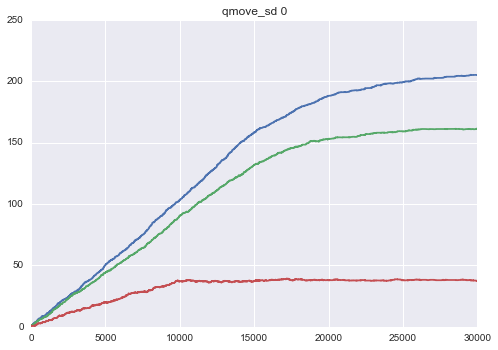

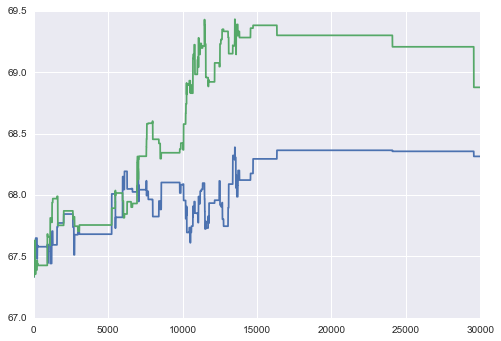

In [41]:
diagnose(channel=[0,1,2])

以上面的是否有趋势为标准，重新设定proposal分布标准差，但不改初始值。

持续时间sd乘1.5，持续时间期望除以5。qshift乘10。

In [12]:
# Inference
T = 30000

#idurations = np.ones([T,replay_num,2],dtype='float32')
#idurations[0,:,:] = np.array([80.0,51.0],dtype='float32')
#qdurations = ed.models.Empirical(tf.Variable(idurations))
#qdurations = ed.models.Empirical(tf.Variable(tf.ones((T,replay_num,2))))
# 这里还从1开始实在不能收敛，试试从等分点开始如何
idurations = np.ones([T,replay_num,2],dtype='float32')
idurations[0,:,:] = np.array([replay_num/3,replay_num/3],dtype='float32')
qdurations = ed.models.Empirical(tf.Variable(idurations))

# 神他妈一堆样板代码，不过没精力想怎么重构了
#ishift_mu = np.ones([T,3],dtype='float32')
#ishift_mu[0,:] = _shift_mu
#qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))
qshift_mu = ed.models.Empirical(tf.Variable(tf.ones((T,3))))

#ictrl_mu = np.ones([T,3],dtype='float32')
#ictrl_mu[0,:] = _ctrl_mu
#qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))
qctrl_mu = ed.models.Empirical(tf.Variable(tf.ones((T,3))))

#ix_mu = np.ones([T,3],dtype='float32')
#ix_mu[0,:] = _x_mu
#qx_mu = ed.models.Empirical(tf.Variable(ix_mu))
qx_mu = ed.models.Empirical(tf.Variable(tf.ones((T,3))))

#imove_mu = np.ones([T,3],dtype='float32')
#imove_mu[0,:] = _move_mu
#qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))
qmove_mu = ed.models.Empirical(tf.Variable(tf.ones((T,3))))

#imove_sd = np.ones([T,3],dtype='float32')
#imove_sd[0,:] = _move_sd
#qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))
qmove_sd = ed.models.Empirical(tf.Variable(tf.ones((T,3))))


# proposal variable

#gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1,0.1],[replay_num,1]).astype('float32'))
gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.01,0.01],[replay_num,1]).astype('float32'))

#poi_scale = 0.000025 # 经实验发现那些泊松的参数接受率太低，故降低游走标准差
poi_scale = 0.01
ggmove_mu_sd = 0.05
gmove_sd_scale = 0.15 # 经实验发现scale有趋势，且在30000次以内不能终结，于是加大其标准差增快搜索

gshift_mu = ed.models.Normal(loc = shift_mu, scale = [poi_scale * 10, poi_scale * 10, poi_scale * 10])
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [poi_scale, poi_scale, poi_scale])
gx_mu = ed.models.Normal(loc = x_mu, scale = [poi_scale, poi_scale, poi_scale])
gmove_mu = ed.models.Normal(loc = move_mu, scale = [ggmove_mu_sd,ggmove_mu_sd,ggmove_mu_sd])
gmove_sd = ed.models.Normal(loc = move_sd, scale = [gmove_sd_scale, gmove_sd_scale, gmove_sd_scale])


In [13]:
from metropolis_hastings_y import MetropolisHastingsY

inference = MetropolisHastingsY({durations: qdurations, 
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      proposal_vars = {durations: gdurations, 
                                       shift_mu: gshift_mu, ctrl_mu: gctrl_mu, x_mu: gx_mu,move_mu: gmove_mu,move_sd: gmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [14]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 564s | Acceptance Rate: 1.984


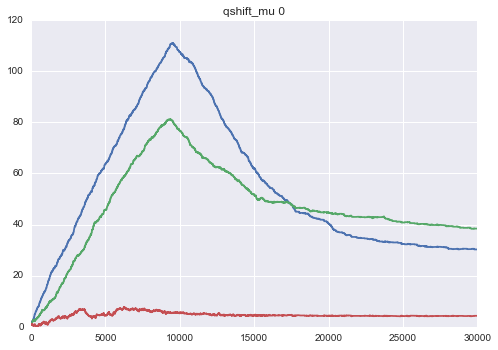

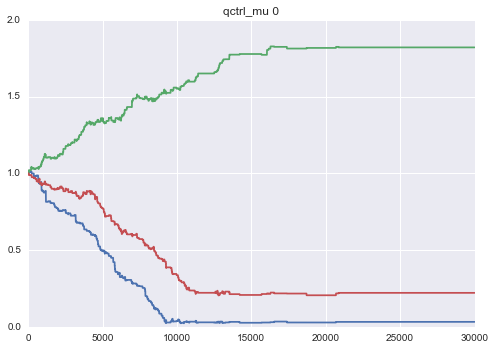

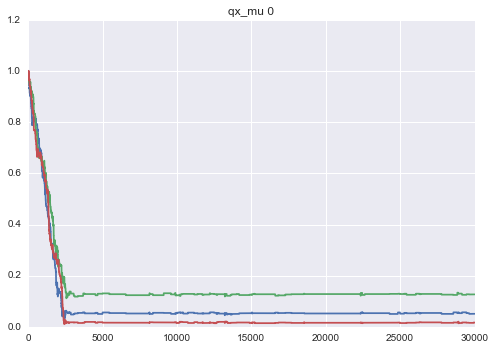

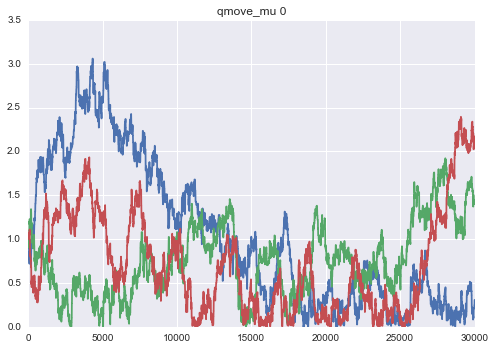

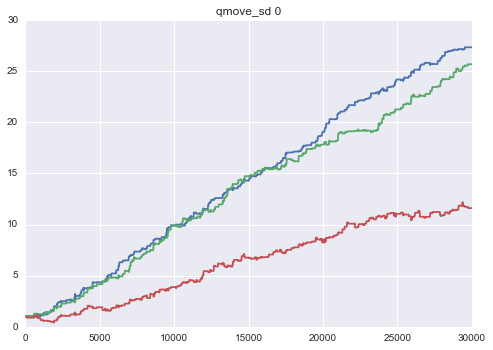

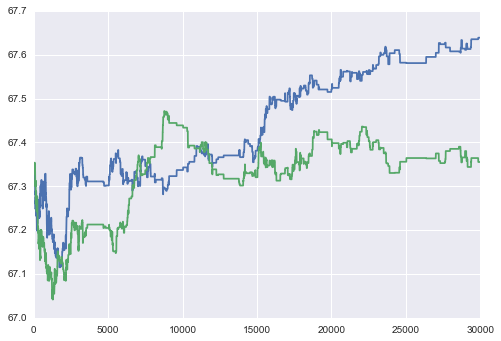

In [15]:
diagnose(channel=[0,1,2])

所以还是用几乎真实值加系统噪声的方法吧。。。实在受不了了，这什么鬼，加上Edward的设计也不好利用上一次迭代的结果。